# Техническое решение команды "**Russian Analysis"**

# **Цель данного проекта:** 
##  Создать рейтинг "надёжности", разбить на классы клиентскую базу и предсказать для каждого класса самый актуальный продукт




# Для достижения поставленной цели решались следующие задачи:
## 1) Изучение специфики предоставленных датасетов
## 2) Анализ и отбор признаков
## 3) Разбиение клиентской базы на классы
## 4) Оценка классов и составление рейтинга
## 5) Определение дальнейших переспектив по развитию проекта 

# Импортируем датасеты и посмотрим на данные



In [ ]:
import pandas as pd
import numpy as np

In [ ]:
agg = pd.read_csv('aggregates.csv', index_col = 0)
tr = pd.read_csv('transactions.csv', index_col = 0)

In [ ]:
tr.head()

,last_day_month,mcc_group,att_sum,att_cnt,att_sum_min,att_sum_max,att_sum_avg
client_id,,,,,,,
1322,2019-12-31,TRANSPORTATION,90.00,3,23.00,44.0,30.000000
7737,2019-05-31,RETAIL STORES,989.00,5,99.00,423.0,197.800000
9549,2020-03-31,NON FOOD RETAIL,11878.55,24,52.79,2303.0,494.939583
4562,2019-12-31,FINANCIAL SERVICES,15000.00,1,15000.00,15000.0,15000.000000
7112,2020-02-29,BUSINESS SERVICES,887.60,3,107.10,413.7,295.866666


In [ ]:
agg.head()

,report_date,cnt_zp_1m,cnt_zp_3m,cnt_zp_6m,cnt_zp_12m,downlimit_count,uplimit_count,limit_exchange_count,cur_credit_limit,cur_cr_lim_month,prev_credit_limit,max_outstanding_amount_1m,max_outstanding_amount_3m,max_outstanding_amount_6m,max_ovd_amount_1m,max_ovd_amount_3m,max_ovd_amount_6m,avg_outstanding_amount_1m,avg_outstanding_amount_3m,avg_outstanding_amount_6m,avg_ovd_amount_1m,avg_ovd_amount_3m,avg_ovd_amount_6m,max_utilization_1m,max_utilization_3m,max_utilization_6m,avg_utilization_1m,avg_utilization_3m,avg_utilization_6m,avg_debt_3m,avg_debt_6m,utilization,total_num_cards,cnt_active,cnt_cur,first_opened,last_opened,last6m_opened,last6m1y_opened,num_credit_cards,...,bank_count_first_12m_60,bank_count_first_12m_90,first_payment_default,second_payment_default,age,cnt_adv_repayment,cnt_adv_repayment_gr_500k,cnt_adv_repayment_gr_100k,cnt_adv_repayment_gr_50k,cnt_adv_repayment_ls_50k,ratio_adv_repayment,ratio_adv_repayment_adv_gr_500k,ratio_adv_repayment_adv_gr_100k,ratio_adv_repayment_adv_gr_50k,ratio_adv_repayment_adv_ls_50k,ratio_cl_closed,ratio_cl_closed_gr500k,ratio_cl_closed_gr100k,ratio_cl_closed_gr50k,ratio_cl_closed_ls50k,avg_liab_sum_total_adv_agr,avg_diff_plan_fact_closed,total_liab_sum_bank_adv_agr,total_liab_sum_bki_adv_agr,cnt_adv25_closed,total_liab_sum_bank_adv25_agr,total_liab_sum_bki_adv25_agr,curdel_0plus_bank,curdel_0plus_bki,curdel_30plus_bank,curdel_30plus_bki,curdel_60plus_bank,curdel_60plus_bki,curdel_tech_bank,curdel_tech_bki,bank_1_29_5y_debtor,bank_30_59_5y_debtor,bank_60_89_5y_debtor,bank_90_119_5y_debtor,bank_120plus_5y_debtor
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4268,2019-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,5.548,5.548,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,49.395161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8951,2019-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.0,125.645,118.516,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,37.731183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3485,2019-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,0.0,120.806,2.129,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,43.954301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8008,2019-11-01 00:00:00,2.0,6.0,12.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,0.0,14.516,0.032,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,39.892473,2.0,0.0,0.0,0.0,2.0,0.666667,NaN,0.000000,0.000000,1.0,0.666667,NaN,0.0,0.0,1.0,15426.0,1.927447,0.0,30852.0,1.0,0.0,3827.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1615,2019-11-01 00:00:00,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,0.0,210.452,20.355,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,57.830645,2.0,0.0,2.0,2.0,0.0,0.666667,0.0,0.666667,0.666667,NaN,1.000000,NaN,1.0,1.0,NaN,226500.0,7.501711,453000.0,0.0,2.0,453000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Посмотрим на среднемесячные расходы клиента:



In [ ]:
mean_monthly_att_sum = tr.groupby(['client_id']).mean()['att_sum']
mean_monthly_att_sum

client_id
0       16021.136061
1       15351.860769
2        1250.258625
3       12969.448788
4       27673.108667
            ...     
9995     6199.517047
9996     8117.848846
9997     5637.803636
9998    11318.515902
9999    32974.162478
Name: att_sum, Length: 9925, dtype: float64

### Дальше будем работать с датасетом портрета клиента (aggregates)

Заполним пропуски нулями, так как в таком случае человек просто не сталкивался с 
данным признаком

In [ ]:
agg.replace([np.inf, -np.inf], np.nan)
agg.fillna(0, inplace = True)

### Выделим важные признаки на основе oбщеэкономических факторов. Таких как: **сфера деятельности**, **тип занимаемой должности**, **общий стаж** и **доход клиента**.

Важно отметить, что кроме общеэкономических факторов есть и индивидуальные. 

* Демографические — возраст, пол, семейное положение и т.д.
* Финансовые — доходы и расходы, доступ к финансовым ресурсам, наличие финансовых резервов.
* Психологические — Лучший источник таких данных — кредитная история. Кредитная история характеризует финансовую дисциплину клиента, содержит информацию о способности погашения конкретных сумм, показывает текущую заинтересованность в займе. Мы возьмем такие признаки как доля закрытых потребительских кредитов (заёмщик), максимальный ежемесячный платеж, срок предыдущего потребительского кредита, количество заявок на потребительские кредиты в истории (по данным гпб), количество заявок на заем, поданное за короткий промежуток, добавляет информации о психотипе заемщика

In [ ]:
features = ['cnt_zp_1m', 'cnt_zp_3m', 'cnt_zp_6m', 'cnt_zp_12m', 'total_num_cards', 'cnt_active',
           'cnt_cur', 'extra_card_ind' , 'gender', 'app_real_estate_ind', 'app_vehicle_ind', 
            'app_last_job_experience_from_val', 'app_last_job_experience_to_val', 
           'app_total_job_experience_val', 'app_addresses_equal', 'app_cc_cnt',
           'app_potreb_cnt', 'app_mrtg_cnt', 'app_lst_potreb_m_term', 'app_fst_request_m_term',
           'sum_sal_acc_inc_6month_amt_rur', 'app_income_from_amt', 'app_income_to_amt', 'min_paym_bank',
           'max_paym_bank', ]
len(features)

25

Сгруппируем наших клиентов по id, чтобы с ними было проще работать

In [ ]:
df = agg[features]
df = df.groupby(['client_id']).mean()

In [ ]:
max_outstanding = agg[['outstanding']].groupby(['client_id']).max()
df = df.join(max_outstanding)
df = df.join(mean_monthly_att_sum)
df.head()

,cnt_zp_1m,cnt_zp_3m,cnt_zp_6m,cnt_zp_12m,total_num_cards,cnt_active,cnt_cur,extra_card_ind,gender,app_real_estate_ind,app_vehicle_ind,app_last_job_experience_from_val,app_last_job_experience_to_val,app_total_job_experience_val,app_addresses_equal,app_cc_cnt,app_potreb_cnt,app_mrtg_cnt,app_lst_potreb_m_term,app_fst_request_m_term,sum_sal_acc_inc_6month_amt_rur,app_income_from_amt,app_income_to_amt,min_paym_bank,max_paym_bank,outstanding,att_sum
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.000000,2.800000,5.000000,7.400000,2.0,0.933333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,7.258,0.0,0.0,0.0,0.0,0.0,0.0,16021.136061
1,1.733333,5.200000,9.600000,14.466667,2.0,0.933333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,7.548,0.0,0.0,0.0,0.0,0.0,0.0,15351.860769
2,1.000000,3.000000,6.000000,12.000000,1.0,0.954545,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,1250.258625
3,2.111111,6.333333,10.666667,12.000000,2.0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,7.484,0.0,0.0,0.0,0.0,0.0,59.8,12969.448788
4,1.636364,4.909091,9.636364,18.909091,1.0,1.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,27673.108667


In [ ]:
df[df['outstanding'] > 0]

,cnt_zp_1m,cnt_zp_3m,cnt_zp_6m,cnt_zp_12m,total_num_cards,cnt_active,cnt_cur,extra_card_ind,gender,app_real_estate_ind,app_vehicle_ind,app_last_job_experience_from_val,app_last_job_experience_to_val,app_total_job_experience_val,app_addresses_equal,app_cc_cnt,app_potreb_cnt,app_mrtg_cnt,app_lst_potreb_m_term,app_fst_request_m_term,sum_sal_acc_inc_6month_amt_rur,app_income_from_amt,app_income_to_amt,min_paym_bank,max_paym_bank,outstanding,att_sum
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,2.111111,6.333333,10.666667,12.000000,2.000000,1.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.0,0.000000,7.484,0.000000,0.000000,0.000000,0.000000,0.000000,5.980000e+01,12969.448788
6,0.681818,2.272727,4.181818,5.545455,2.090909,0.590909,0.0,1.000000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.272727,0.000000,0.0,0.000000,100.855,802.909091,0.000000,0.000000,0.000000,0.000000,2.127290e+06,12867.145682
11,0.000000,0.000000,0.000000,0.000000,1.000000,0.681818,0.0,0.000000,0.0,0.0,0.000000,71.000000,71.000000,93.000000,1.000000,0.000000,2.000000,0.0,20.016000,26.081,0.000000,56116.931000,56116.931000,14015.317076,14015.317076,8.695618e+05,14306.273750
14,0.000000,0.409091,2.727273,12.590909,2.727273,0.727273,0.0,1.000000,1.0,0.0,0.000000,22.045455,22.045455,0.000000,0.272727,0.272727,6.954545,1.0,9.781727,74.823,121920.440000,24092.452636,24092.452636,0.000000,14024.406026,4.838017e+06,23738.760682
15,1.090909,3.272727,6.545455,13.090909,3.000000,1.000000,0.0,0.227273,0.0,0.0,0.000000,106.000000,106.000000,144.000000,0.000000,0.136364,2.000000,0.0,35.984000,69.177,194778.540000,32463.090000,32463.090000,0.000000,0.000000,3.062174e+04,6991.604709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9986,1.444444,5.222222,11.888889,23.333333,5.000000,2.000000,0.0,1.000000,0.0,0.0,0.222222,116.444444,116.444444,169.111111,0.888889,0.000000,3.555556,0.0,24.677000,38.161,0.000000,61347.508578,61347.508578,0.000000,26577.376686,2.445386e+06,9066.026588
9987,2.409091,7.045455,14.090909,27.545455,6.227273,1.454545,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.454545,0.954545,0.454545,0.0,2.250909,108.565,192396.482727,0.000000,0.000000,6862.279773,6862.279773,9.107595e+05,8490.207447
9988,0.000000,0.000000,0.000000,0.100000,1.000000,1.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,4.698483e+04,26653.552099


# Перед нами классическая задача машинного обучения на unsupervised learning.
## Для успешного её решения необходимо выполнить следующие пункты:

**1.**  **Привести данные в общий формат**

**2.**  **Сделать очистку по корреляции**

**3.**  **Нормализовать по признакам**

**4.**  **Визуализировать по классам (кластеризация, t-sne)**

**5.**  **Визуализировать по признакам**

## В общий формат мы привели, теперь делаем очистку по корреляции
Для этого воспользуемся инструментом, который был взят из open source и немного нами доработан

No labels provided. Feature importance based methods are not available.
5 features with a correlation magnitude greater than 0.70.



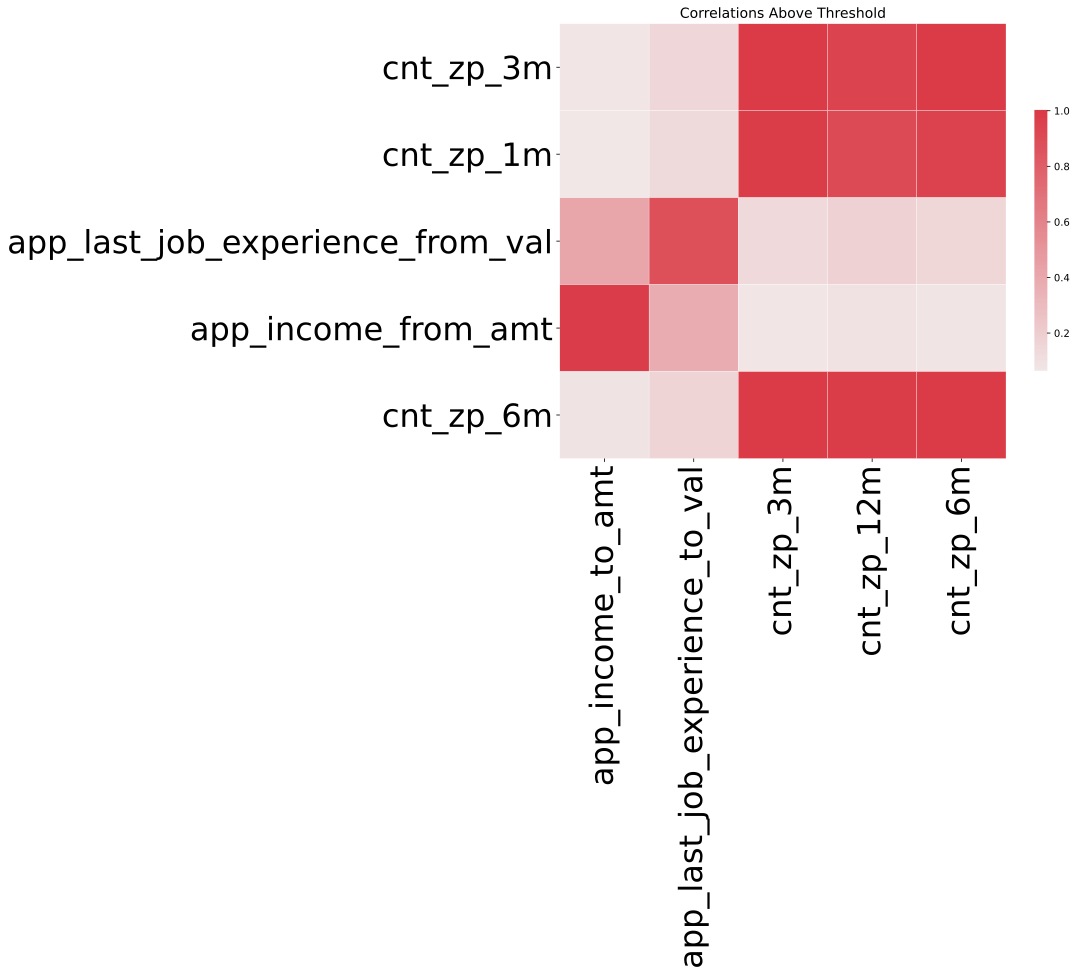

In [ ]:
from feature_selector import FeatureSelector
fs = FeatureSelector(data=df)
fs.identify_collinear(correlation_threshold=0.7)
fs.plot_collinear()

In [ ]:
collinear_features = fs.ops['collinear']
df.drop(collinear_features, axis=1, inplace=True)
features = [f for f in features if f not in collinear_features]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9895 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   cnt_zp_1m                         9895 non-null   float64
 1   total_num_cards                   9895 non-null   float64
 2   cnt_active                        9895 non-null   float64
 3   cnt_cur                           9895 non-null   float64
 4   extra_card_ind                    9895 non-null   float64
 5   gender                            9895 non-null   float64
 6   app_real_estate_ind               9895 non-null   float64
 7   app_vehicle_ind                   9895 non-null   float64
 8   app_last_job_experience_from_val  9895 non-null   float64
 9   app_total_job_experience_val      9895 non-null   float64
 10  app_addresses_equal               9895 non-null   float64
 11  app_cc_cnt                        9895 non-null   float64
 12  app_po

## Нормализуем при помощи MinMaxScaler()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(df[features])
df_scaled = scaler.transform(df[features])

## Теперь приступим к визуализации при помощи t-sne

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
import numpy as np
from sklearn.manifold import TSNE

In [ ]:
%%time
tsne = TSNE(random_state=42)
tsne_representation = tsne.fit_transform(df_scaled)

CPU times: user 3min 9s, sys: 768 ms, total: 3min 10s
Wall time: 1min 38s


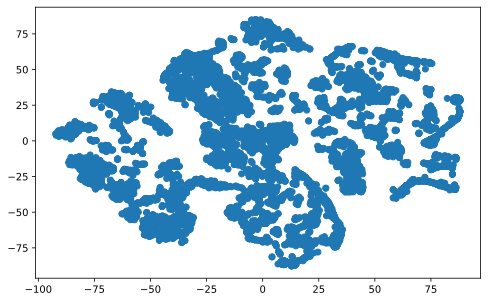

In [ ]:
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1])

Из изображения выше видно, что есть вероятность успешного разбиения данных на кластеры.

## Применяем k-means

Метод k-средних можно рассматривать как случай гауссовой смеси распределений, в котором каждый кластер имеет одинаковый вес, сферообразную форму и одинаковый радиус.

Чтобы отобрать оптимальное число кластеров, воспользуемся методом "локтя"

In [ ]:
from sklearn.cluster import KMeans

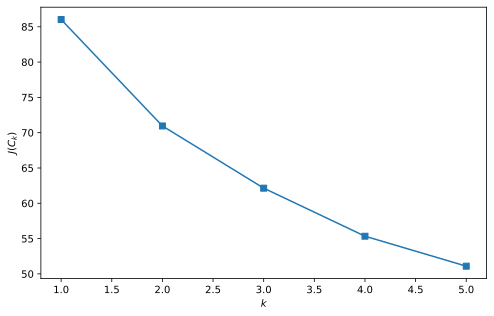

In [ ]:
inertia = []
for k in range(1, 6):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(df_scaled)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 6), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

Выберем число кластеров и получим метки классов для каждого id

In [ ]:
clusterNum = 5
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(df_scaled)
labels = k_means.labels_
print(labels)

[0 0 0 ... 3 3 3]


In [ ]:
import copy
new_df  = df
new_df["Cluster_label"] = labels
final = copy.deepcopy(new_df)
new_df.head(5)

,cnt_zp_1m,total_num_cards,cnt_active,cnt_cur,extra_card_ind,gender,app_real_estate_ind,app_vehicle_ind,app_last_job_experience_from_val,app_total_job_experience_val,app_addresses_equal,app_cc_cnt,app_potreb_cnt,app_mrtg_cnt,app_lst_potreb_m_term,app_fst_request_m_term,sum_sal_acc_inc_6month_amt_rur,app_income_from_amt,min_paym_bank,max_paym_bank,outstanding,att_sum,Cluster_label
client_id,,,,,,,,,,,,,,,,,,,,,,,
0,1.000000,2.0,0.933333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,7.258,0.0,0.0,0.0,0.0,0.0,16021.136061,0
1,1.733333,2.0,0.933333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,7.548,0.0,0.0,0.0,0.0,0.0,15351.860769,0
2,1.000000,1.0,0.954545,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,1250.258625,0
3,2.111111,2.0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,7.484,0.0,0.0,0.0,0.0,59.8,12969.448788,0
4,1.636364,1.0,1.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,27673.108667,3


In [ ]:
new_df.groupby('Cluster_label').mean()

,cnt_zp_1m,total_num_cards,cnt_active,cnt_cur,extra_card_ind,gender,app_real_estate_ind,app_vehicle_ind,app_last_job_experience_from_val,app_total_job_experience_val,app_addresses_equal,app_cc_cnt,app_potreb_cnt,app_mrtg_cnt,app_lst_potreb_m_term,app_fst_request_m_term,sum_sal_acc_inc_6month_amt_rur,app_income_from_amt,min_paym_bank,max_paym_bank,outstanding,att_sum
Cluster_label,,,,,,,,,,,,,,,,,,,,,,
0,0.928846,1.747768,0.972785,0.004476,0.033610,0.006865,0.006621,0.007618,2.426236,3.535901,0.055092,0.182726,0.122587,0.037404,0.972280,4.216925,18611.296513,2506.646461,495.658452,622.266027,3.173956e+05,16928.121941
1,1.855773,3.894868,1.896929,0.027863,0.983159,0.978960,0.073200,0.035595,19.902969,22.453529,0.343558,0.465310,0.849334,0.234862,11.110640,64.092171,250104.283197,15920.717530,757.741877,1916.280274,1.462519e+06,17627.433686
2,1.874123,4.015983,1.841316,0.026027,0.892267,0.000000,0.100004,0.097874,40.013715,50.194852,0.896089,0.398331,2.082809,0.409438,17.628519,67.728867,351590.725825,36821.832391,1858.024350,5563.582580,3.159890e+06,21724.571314
3,1.446788,2.908908,1.476655,0.040160,0.975673,0.016184,0.029814,0.032199,6.398969,5.946569,0.032652,0.247485,0.339696,0.090830,5.387107,29.327688,146747.102026,5942.373717,499.133118,1028.051977,5.883411e+05,22593.747221
4,1.324795,2.228192,1.060233,0.002955,0.053177,0.926037,0.035803,0.023614,10.296829,15.859034,0.219551,0.516191,0.319663,0.110772,3.519460,16.311696,37504.569431,9967.897547,1193.855806,1524.909297,1.026052e+06,14839.577365


##Воспользуемся Гауссовой моделью смесей для определения вероятности преналежности каждого id к кластеру

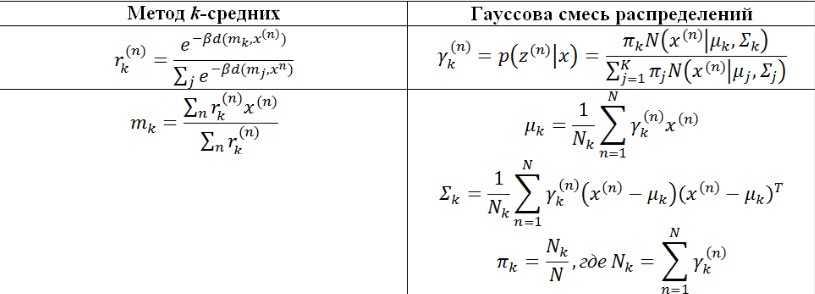

In [ ]:
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal as mvn
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(df[features])
gmm = GaussianMixture(n_components=5, covariance_type='full').fit(Y_sklearn)
prediction_gmm = gmm.predict(Y_sklearn)
probs = gmm.predict_proba(Y_sklearn)
probs[6]

array([0.00000000e+00, 1.37615928e-06, 9.99804630e-01, 9.44405112e-07,
       1.93049602e-04])

In [ ]:
labels = np.zeros([len(probs), 1], dtype = float) 
for indx, array in enumerate(probs):
    probability = max(array)
    labels[indx] = list(array).index(probability)
df["Cluster_label"] = labels

## Объединим изначальные данные и label-кластеров

In [ ]:
result_df = pd.merge(new_df, agg, on='client_id')
clusters_mean = result_df.groupby('Cluster_label').mean()

## Получим среднее количество открытых кредитов по категориям

In [ ]:
products_classes = ['auto_open', 'micro_open', 'other_open']
clusters_mean[products_classes]

,auto_open,micro_open,other_open
Cluster_label,,,
0.0,0.003457,0.004740,0.002079
1.0,0.037998,0.002148,0.002974
2.0,0.007099,0.009584,0.004792
3.0,0.021638,0.000000,0.000000
4.0,0.015442,0.019186,0.006265


### Выведем самую популярную категорию в кластерах

In [ ]:
clusters_mean[products_classes].idxmax(axis=1)

Cluster_label
0.0    micro_open
1.0     auto_open
2.0    micro_open
3.0     auto_open
4.0    micro_open
dtype: object

### Получим среднее количество открытых кредитов по сумме в кластере

In [ ]:
consumer_credits = ['cl_closed_gr500k', 'cl_closed_gr100k', 'cl_closed_gr50k', 'cl_closed_ls50k']
clusters_mean[consumer_credits]

,cl_closed_gr500k,cl_closed_gr100k,cl_closed_gr50k,cl_closed_ls50k
Cluster_label,,,,
0.0,0.020376,0.090376,0.142782,0.238114
1.0,0.956550,2.234429,2.593590,1.050388
2.0,0.075892,0.523206,0.720586,0.780860
3.0,1.404946,2.352396,2.646059,0.281298
4.0,0.254191,1.517167,2.025549,2.050437


### Выведем самую популярную категорию "потребительского кредита" в кластерах

In [ ]:
clusters_mean[consumer_credits].idxmax(axis=1)

Cluster_label
0.0    cl_closed_ls50k
1.0    cl_closed_gr50k
2.0    cl_closed_ls50k
3.0    cl_closed_gr50k
4.0    cl_closed_ls50k
dtype: object

## Итог: Клиенты были разбиты на классы, для каждого класса был получен самый актуальный продукт 

#Теперь надо составить рейтинг клиентов
##Для этого разделим всех клиентов на 2 категории (более и менее надёжные), затем реализуем формулу которая отразит "успех клиента"

In [ ]:
agg = pd.read_csv('aggregates.csv', index_col = 0)
tr = pd.read_csv('transactions.csv', index_col = 0)

In [ ]:
final.head()

,cnt_zp_1m,total_num_cards,cnt_active,cnt_cur,extra_card_ind,gender,app_real_estate_ind,app_vehicle_ind,app_last_job_experience_from_val,app_total_job_experience_val,app_addresses_equal,app_cc_cnt,app_potreb_cnt,app_mrtg_cnt,app_lst_potreb_m_term,app_fst_request_m_term,sum_sal_acc_inc_6month_amt_rur,app_income_from_amt,min_paym_bank,max_paym_bank,outstanding,att_sum,Cluster_label
client_id,,,,,,,,,,,,,,,,,,,,,,,
0,1.000000,2.0,0.933333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,7.258,0.0,0.0,0.0,0.0,0.0,16021.136061,0
1,1.733333,2.0,0.933333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,7.548,0.0,0.0,0.0,0.0,0.0,15351.860769,0
2,1.000000,1.0,0.954545,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,1250.258625,0
3,2.111111,2.0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,7.484,0.0,0.0,0.0,0.0,59.8,12969.448788,0
4,1.636364,1.0,1.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,27673.108667,3


In [ ]:
agg.head()

,report_date,cnt_zp_1m,cnt_zp_3m,cnt_zp_6m,cnt_zp_12m,downlimit_count,uplimit_count,limit_exchange_count,cur_credit_limit,cur_cr_lim_month,prev_credit_limit,max_outstanding_amount_1m,max_outstanding_amount_3m,max_outstanding_amount_6m,max_ovd_amount_1m,max_ovd_amount_3m,max_ovd_amount_6m,avg_outstanding_amount_1m,avg_outstanding_amount_3m,avg_outstanding_amount_6m,avg_ovd_amount_1m,avg_ovd_amount_3m,avg_ovd_amount_6m,max_utilization_1m,max_utilization_3m,max_utilization_6m,avg_utilization_1m,avg_utilization_3m,avg_utilization_6m,avg_debt_3m,avg_debt_6m,utilization,total_num_cards,cnt_active,cnt_cur,first_opened,last_opened,last6m_opened,last6m1y_opened,num_credit_cards,...,bank_count_first_12m_60,bank_count_first_12m_90,first_payment_default,second_payment_default,age,cnt_adv_repayment,cnt_adv_repayment_gr_500k,cnt_adv_repayment_gr_100k,cnt_adv_repayment_gr_50k,cnt_adv_repayment_ls_50k,ratio_adv_repayment,ratio_adv_repayment_adv_gr_500k,ratio_adv_repayment_adv_gr_100k,ratio_adv_repayment_adv_gr_50k,ratio_adv_repayment_adv_ls_50k,ratio_cl_closed,ratio_cl_closed_gr500k,ratio_cl_closed_gr100k,ratio_cl_closed_gr50k,ratio_cl_closed_ls50k,avg_liab_sum_total_adv_agr,avg_diff_plan_fact_closed,total_liab_sum_bank_adv_agr,total_liab_sum_bki_adv_agr,cnt_adv25_closed,total_liab_sum_bank_adv25_agr,total_liab_sum_bki_adv25_agr,curdel_0plus_bank,curdel_0plus_bki,curdel_30plus_bank,curdel_30plus_bki,curdel_60plus_bank,curdel_60plus_bki,curdel_tech_bank,curdel_tech_bki,bank_1_29_5y_debtor,bank_30_59_5y_debtor,bank_60_89_5y_debtor,bank_90_119_5y_debtor,bank_120plus_5y_debtor
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4268,2019-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,5.548,5.548,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,49.395161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8951,2019-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.0,125.645,118.516,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,37.731183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3485,2019-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,0.0,120.806,2.129,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,43.954301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8008,2019-11-01 00:00:00,2.0,6.0,12.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,0.0,14.516,0.032,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,39.892473,2.0,0.0,0.0,0.0,2.0,0.666667,NaN,0.000000,0.000000,1.0,0.666667,NaN,0.0,0.0,1.0,15426.0,1.927447,0.0,30852.0,1.0,0.0,3827.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1615,2019-11-01 00:00:00,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,0.0,210.452,20.355,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,57.830645,2.0,0.0,2.0,2.0,0.0,0.666667,0.0,0.666667,0.666667,NaN,1.000000,NaN,1.0,1.0,NaN,226500.0,7.501711,453000.0,0.0,2.0,453000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
tr.head()

,last_day_month,mcc_group,att_sum,att_cnt,att_sum_min,att_sum_max,att_sum_avg
client_id,,,,,,,
1322,2019-12-31,TRANSPORTATION,90.00,3,23.00,44.0,30.000000
7737,2019-05-31,RETAIL STORES,989.00,5,99.00,423.0,197.800000
9549,2020-03-31,NON FOOD RETAIL,11878.55,24,52.79,2303.0,494.939583
4562,2019-12-31,FINANCIAL SERVICES,15000.00,1,15000.00,15000.0,15000.000000
7112,2020-02-29,BUSINESS SERVICES,887.60,3,107.10,413.7,295.866666


In [ ]:
mean_monthly_att_sum = tr.groupby(['client_id']).mean()['att_sum']
mean_monthly_att_sum

client_id
0       16021.136061
1       15351.860769
2        1250.258625
3       12969.448788
4       27673.108667
            ...     
9995     6199.517047
9996     8117.848846
9997     5637.803636
9998    11318.515902
9999    32974.162478
Name: att_sum, Length: 9925, dtype: float64

In [ ]:
agg.fillna(0, inplace = True)

###Выделяем важные для для данной задачи признаки

In [ ]:
features = ['cnt_zp_3m',
 'app_client_category',
 'app_real_estate_ind',
 'app_education_nm',
 'app_potreb_cnt',
 'sum_sal_acc_inc_6month_amt_rur',
 'cnt_zp_1m',
 'app_rel_status',
 'cnt_zp_12m',
 'app_income_from_amt',
 'app_employment_type_nm',
 'max_paym_bank',
 'gender',
 'cnt_active',
 'extra_card_ind',
 'app_lst_potreb_m_term',
 'app_phone_home_flag',
 'app_fst_request_m_term',
 'app_last_job_experience_from_val',
 'app_addresses_equal',
 'app_vehicle_ind',
 'app_mrtg_cnt',
 'app_position_type_nm',
 'app_total_job_experience_val',
 'cnt_zp_6m',
 'app_income_to_amt',
 'min_paym_bank',
 'app_last_job_experience_to_val',
 'app_cc_cnt',
 'app_industry_nm',
 'total_num_cards',
 'cnt_cur']

list(set(features))

['app_employment_type_nm',
 'app_income_to_amt',
 'app_mrtg_cnt',
 'app_position_type_nm',
 'app_rel_status',
 'app_phone_home_flag',
 'cnt_zp_1m',
 'app_last_job_experience_from_val',
 'app_total_job_experience_val',
 'sum_sal_acc_inc_6month_amt_rur',
 'app_vehicle_ind',
 'cnt_active',
 'app_cc_cnt',
 'extra_card_ind',
 'app_potreb_cnt',
 'app_real_estate_ind',
 'app_last_job_experience_to_val',
 'cnt_zp_3m',
 'min_paym_bank',
 'app_education_nm',
 'cnt_zp_6m',
 'app_lst_potreb_m_term',
 'app_addresses_equal',
 'cnt_cur',
 'max_paym_bank',
 'gender',
 'cnt_zp_12m',
 'app_income_from_amt',
 'app_industry_nm',
 'total_num_cards',
 'app_client_category',
 'app_fst_request_m_term']

###Разделим датасет на 2 кластера. Вероятность принадлежности кредитной истории к одному из них будет являться оценкой

In [ ]:
agg.drop(features, axis = 1, inplace = True)

In [ ]:
agg = agg.groupby('client_id').mean()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(agg)
agg = scaler.transform(agg)

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, covariance_type='full').fit(agg)
prediction_gmm = gmm.predict(agg)
probs = gmm.predict(agg)

In [ ]:
client_clusters = final['Cluster_label'].to_list()

##Перемножим взвешенные номера класса клиента из первого датасета на номер класса из второго и получим некоторый скор, который **определит позицию в рейтинге**

In [ ]:
w_client = .5
w_credit = .3
raiting = []

for i in range(len(probs)):
    r = w_client * client_clusters[i] + w_credit * probs[i]
    raiting.append(r)

In [ ]:
df = pd.DataFrame(raiting, final.index)
df.sort_values(0, ascending = False)

,0
client_id,
1754,2.3
4329,2.3
4336,2.3
800,2.3
6582,2.3
...,...
2461,0.0
2451,0.0
5905,0.0
